### Human voice to Robot voice

In [ ]:
%pip install soundfile scipy numpy pywavelets librosa matplotlib simpleaudio pydub

In [17]:
import soundfile as sf
import numpy as np
import pandas as pd 
import pywt
import librosa
import wave
import simpleaudio as sa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython.display as ipd
from scipy.signal import butter, lfilter
from pydub import AudioSegment

Function to plot the signal

In [18]:
# Plot the signal
def plotSignal(filename):
    with wave.open(filename, 'rb') as wav_file:
        # Extract the signal and the sample rate
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype='int16')
        fs = wav_file.getframerate()

    # Compute the time vector
    time = np.arange(signal.size) / fs

    # Plot the waveform
    plt.plot(time, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform of {}".format(filename))
    plt.show()

Function to perform noise cancellation

In [19]:
def cancelTheNoise(fs, signal, file):
    # Define the filter parameters
    cutoff_freq = 1000  # Hz
    filter_order = 5

    # Create a Butterworth filter
    nyquist_freq = 0.5 * fs
    cutoff = cutoff_freq / nyquist_freq
    b, a = butter(filter_order, cutoff, btype="highpass")

    # Apply the filter to the signal
    filtered_signal = lfilter(b, a, signal)

    # Save the filtered signal to a new WAV file
    wav.write(file, fs, ((filtered_signal + filtered_signal.min()) * (2 ** 15) / filtered_signal.ptp()).astype(np.int16))

    # plotSignal("filtered.wav")

Load source voice and target voice signals

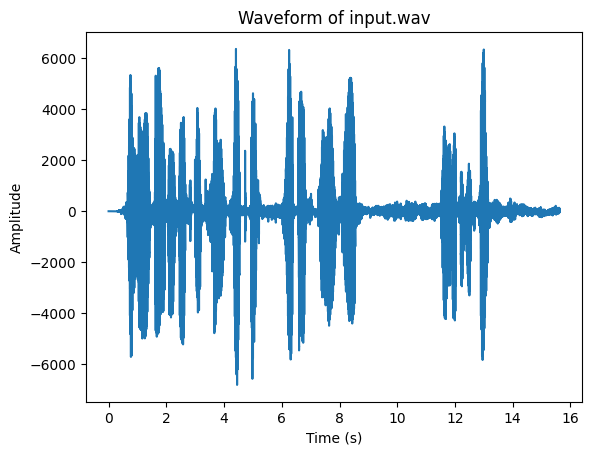

input.wav


In [20]:
file = "input.wav"

# Load the WAV file
fs, signal = wav.read(file)

plotSignal(file)

print(file)
ipd.Audio(file)

Perform Noise filtering

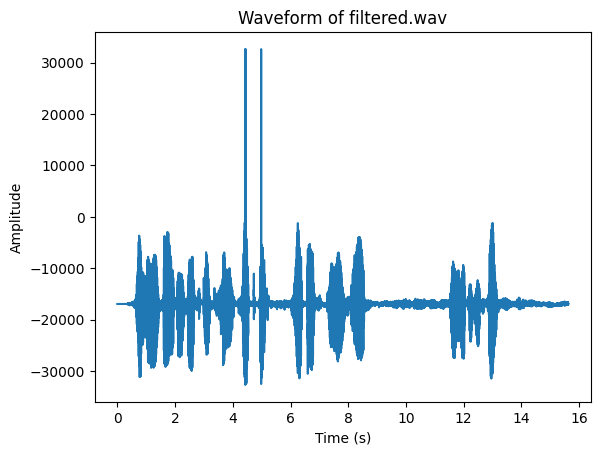

filtered.wav


In [21]:
cancelTheNoise(fs, signal, "filtered.wav")

plotSignal("filtered.wav")

print("filtered.wav")
ipd.Audio("filtered.wav")

## Feature Extraction

Perform Discrete Wavelet Transform

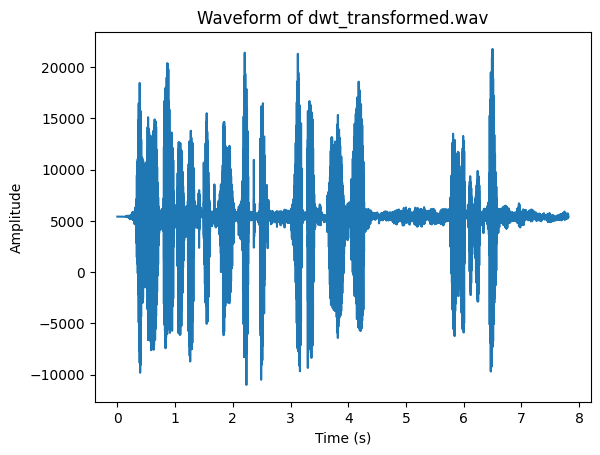

dwt_transformed.wav:


In [22]:
# Load the filtered WAV file
fs, signal = wav.read('filtered.wav')

if signal.ndim > 1:
    signal = signal.mean(axis=1)

# Define the wavelet to use and the number of decomposition levels
wavelet = 'db4'
levels = 3

# Perform the discrete wavelet transform
coeffs = pywt.wavedec(signal, wavelet, level=levels)

# Get the approximation coefficients (i.e., the reconstructed low-pass component)
approx = pywt.upcoef('a', coeffs[0], wavelet, level=levels, take=len(signal))

# # Save the approximation coefficients to a new WAV file
wav.write("dwt_transformed.wav", fs, ((approx + approx.min()) * (2 ** 15) / approx.ptp()).astype(np.int16))

plotSignal("dwt_transformed.wav")

print("dwt_transformed.wav:")
ipd.Audio("dwt_transformed.wav")

Divide the generated approximation wav file into small frames of fixed time period

In [23]:
# Load the filtered WAV file
fs, signal = wav.read('dwt_transformed.wav')
signalLibrosa, fsLibrosa = librosa.load("dwt_transformed.wav", sr=None, mono=True)

# Define the frame length and hop length in seconds
frame_length = 0.1  # seconds
hop_length = 0.05  # seconds

# Convert the frame and hop lengths to samples
frame_length_samples = int(frame_length * fs)
hop_length_samples = int(hop_length * fs)

# Divide the signal into frames
frames = librosa.util.frame(signal, frame_length=frame_length_samples, hop_length=hop_length_samples)

Compute spectral envelope using lpc method

In [24]:
# Apply pre-emphasis filter
signal = librosa.effects.preemphasis(signal.astype(np.float32), 0.95)

# Set the order of the cepstral analysis
order = 10

In [25]:
# Initialize an empty list to hold the spectral envelopes
spectral_envelopes = []

# Iterate over each frame
for i in range(frames.shape[1]):
    # Get the current frame
    frame = frames[:, i]
    
    # Apply window to the frame
    frame_windowed = frame * np.hamming(frame_length_samples)
    
    # Compute the LPC coefficients using autocorrelation method
    lpc_coeffs = librosa.lpc(frame_windowed, order)
    
    # Compute the roots of the LPC polynomial to obtain the poles
    poles = np.roots(lpc_coeffs)
    
    # Convert the poles to frequencies
    freqs = np.arctan2(poles.imag, poles.real) * (fs / (2*np.pi))
    
    # Compute the magnitude of the poles to obtain the spectral envelope
    mags = np.abs(lfilter(lpc_coeffs, [1], np.exp(-2j*np.pi*freqs/fs)))
    
    # Normalize the spectral envelope
    mags /= mags.max()
    
    # Append the spectral envelope to the list
    spectral_envelopes.append(mags)

Concatenate extracted features of each frame into a feature vector

In [26]:
# Concatenate the spectral envelopes of each frame into a feature vector
feature_vector = np.hstack(spectral_envelopes)

feature_vector, len(feature_vector)

(array([0.41933297, 0.16026921, 0.13602108, ..., 0.84645089, 0.6305011 ,
        0.44472713]),
 1550)

## Voice Synthesis

Apply signal processing techniques (phase vocoder)

In [27]:
# Define the frame length and hop length in seconds
frame_length = 0.1  # seconds
hop_length = 0.05   # seconds

# Convert the frame and hop lengths to samples
frame_length_samples = int(frame_length * fsLibrosa)
hop_length_samples = int(hop_length * fsLibrosa)

# Apply pre-emphasis filter
signal_preemphasized = librosa.effects.preemphasis(signalLibrosa, 1)

# Define the speed-up factor
speed_up_factor = 1

# Apply phase vocoder
spectrogram = librosa.stft(signal_preemphasized)
spectrogram_stretched = librosa.phase_vocoder(spectrogram, speed_up_factor, hop_length=hop_length_samples)

Save synthesized voice as a audio file

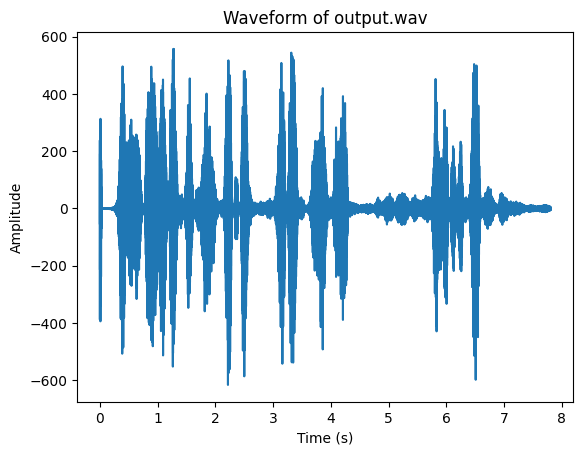

output.wav:


In [28]:
# Set the sampling rate and window size
sr = 48000

waveform = librosa.griffinlim(spectrogram)

# Save the synthetic speech waveform as an audio file
sf.write('output.wav', waveform, sr)

plotSignal("output.wav")

print("output.wav:")
ipd.Audio("output.wav")

Enhanced output audio

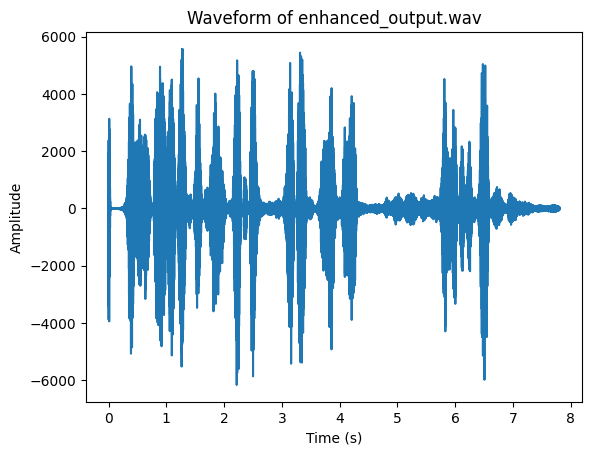

enhanced_output.wav:


In [29]:
audio = AudioSegment.from_wav("output.wav")

audio = audio + 20

audio.export("enhanced_output.wav", "wav")

plotSignal("enhanced_output.wav")

print("enhanced_output.wav:")
ipd.Audio("enhanced_output.wav")

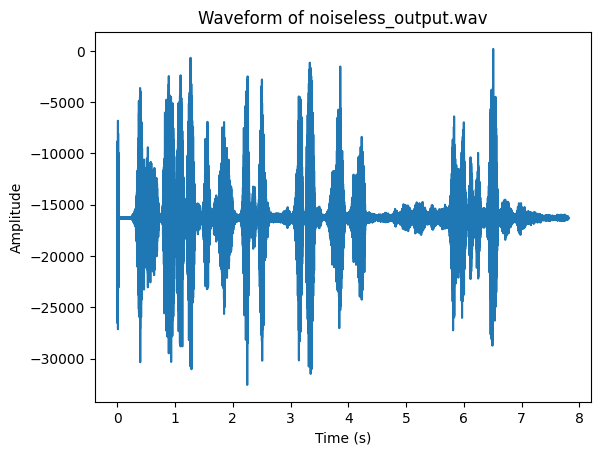

noiseless_output.wav


In [30]:
# Load the WAV file
fs, signal = wav.read('enhanced_output.wav')

cancelTheNoise(fs, signal, "noiseless_output.wav")

plotSignal("noiseless_output.wav")

print("noiseless_output.wav")
ipd.Audio("noiseless_output.wav")